# Исследование влияния наличия нескольких экспоненциальных составляющих в спектре на коэффициент нелинейности-неэкспоненциальности

## 1. Импорт необходимых библиотек и модулей

In [1]:
from joblib import Parallel, delayed

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline

from fsmodels import FrequencyScan

## 2. Модель частотного скана с для сигнала релаксации с одной экспоненциальной составляющей и коэффициентом нелинейности-неэкспоненциальности

### 2.1.  Описание модели в формулах
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ - масштабный множитель.

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

### 2.2. Кодирование модели
$$ \tau = 10^{time\_constant\_power} $$

$$ F_0 = 10^{frequency\_power}$$

$$ a = \tau F_0 $$

$$ b = t_1 F_0 $$

$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$

$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$

$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$

$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$  M = \frac{1}{\max{\left[
    a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right)
    \right]}}
$$

$$ S\left(\tau, A, F_0, t_1, p\right) = A\left[\phi\left(\tau,F_0,t_1\right)\right]^p $$

```Python
from fsmodels import FrequencyScan
```

## 3. Проверка модели. Пример 1.
- Постоянная времени: $\tau=0.005$ с.
- Амплитуда: $A=3.0$ .
- Длительность импульса заполнения: $t_1=20\cdot10^{-6}$ с.
- Коэффициент нелинейности-неэкспоненциальности: $p=1.0$

### 3.1. Чтение данных

In [2]:
data = pd.read_csv('test.csv', header = 0)
data['temperature_k'] = 298.0
data = data[['f_pulse', 'temperature_k', 'frequency_hz', 'dlts_pf']]

data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,1.000000,0.024528
1,0.00002,298.0,1.007863,-0.200976
2,0.00002,298.0,1.015787,0.004056
3,0.00002,298.0,1.023774,0.252659
4,0.00002,298.0,1.031823,0.307020


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   f_pulse        1000 non-null   float64
 1   temperature_k  1000 non-null   float64
 2   frequency_hz   1000 non-null   float64
 3   dlts_pf        1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


### 3.2 График данных до масштабирования

In [4]:
def plot_experimental_data(data, freq_ix=0, dlts_ix=1, semilogx=False):
    array = np.array(data)
    xlim = np.array([1, 2500])
    if semilogx:
        plt.semilogx(array[:, freq_ix], array[:, dlts_ix], '.g', label='Экспериментальные\nданные', alpha = 0.3)
        plt.xlim(xlim)
        plt.xlabel('Частота, Гц')
    else:
        plt.plot(array[:, freq_ix], array[:, dlts_ix], '.g', label='Экспериментальные\nданные', alpha = 0.3)
        plt.xlim(np.log10(xlim))
        plt.xlabel('log10(Частота, Гц)')
        
    plt.grid()
    plt.legend()
    plt.ylabel('DLTS')
    plt.show()

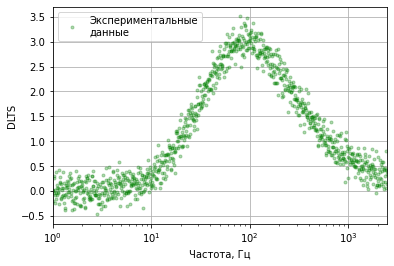

In [5]:
plot_experimental_data(data, freq_ix=2, dlts_ix=3, semilogx=True)

### 3.3. Нормализация (масштабирование) данных
Переход к десятичному логарифму частоты

In [6]:
data.frequency_hz = np.log10(data.frequency_hz)
data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,0.000000,0.024528
1,0.00002,298.0,0.003401,-0.200976
2,0.00002,298.0,0.006803,0.004056
3,0.00002,298.0,0.010204,0.252659
4,0.00002,298.0,0.013605,0.307020


### 3.4. График данных после нормализации 

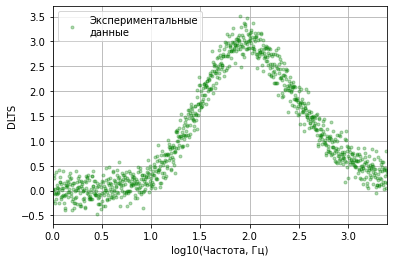

In [7]:
plot_experimental_data(data, freq_ix=2, dlts_ix=3, semilogx=False)

### 3.5. Преобразование к массива 

In [8]:
data = data.to_numpy()

### 3.6. Идентификация параметров модели без изменения $p$

In [9]:
fs = FrequencyScan(time_constant_power = -1.25,
                   amplitude = 2.25,
                   fit_p_coef = False,
                   learning_rate = 0.2,
                   n_iters = 1000,
                   stop_val = 10**-10,
                   verbose = True,
                   
                   tf_in_out = False
                  )

initial_dlts = fs(data[:,2])

fit_results = fs.fit(data[:,2], data[:,3])

iter # 0
amp: 2.25
tau: -1.25
p: 1.0
Loss: 2.325732312107583
iter # 1
amp: 2.1368784814963813
tau: -1.6959813344825185
p: 1.0
Loss: 1.1697847081890635
iter # 2
amp: 2.1381291725109985
tau: -2.205618001906826
p: 1.0
Loss: 0.25700931149209555
iter # 3
amp: 2.225195597570135
tau: -2.3212402569327155
p: 1.0
Loss: 0.19449363611302528
iter # 4
amp: 2.3057949488171205
tau: -2.2920481225654705
p: 1.0
Loss: 0.162215688977927
iter # 5
amp: 2.3779889346762046
tau: -2.301483802728193
p: 1.0
Loss: 0.13736303114005405
iter # 6
amp: 2.4426505977070563
tau: -2.2982805588016237
p: 1.0
Loss: 0.11754113984038496
iter # 7
amp: 2.5005215710598345
tau: -2.299773236441441
p: 1.0
Loss: 0.1016694005173332
iter # 8
amp: 2.552327434932032
tau: -2.2992980152116886
p: 1.0
Loss: 0.08895403323128474
iter # 9
amp: 2.5986979900439104
tau: -2.299689866041357
p: 1.0
Loss: 0.07876621018854504
iter # 10
amp: 2.6402061180521783
tau: -2.2996450108932875
p: 1.0
Loss: 0.07060340109105323
iter # 11
amp: 2.6773604078533917
tau:

iter # 91
amp: 2.994423789565903
tau: -2.300516439812314
p: 1.0
Loss: 0.037697245022443523
iter # 92
amp: 2.9944284939660246
tau: -2.3005164506656657
p: 1.0
Loss: 0.03769724491758863
iter # 93
amp: 2.994432704983491
tau: -2.3005164603807504
p: 1.0
Loss: 0.03769724483357408


In [10]:
fit_results.to_csv('../models/identification_test.csv', index=False)
fit_results

,amplitude,time_constant_power,p_coef,loss
0,2.25,-1.25,1.0,2.325732
1,2.136878,-1.695981,1.0,1.169785
2,2.138129,-2.205618,1.0,0.257009
3,2.225196,-2.32124,1.0,0.194494
4,2.305795,-2.292048,1.0,0.162216
...,...,...,...,...
89,2.994413,-2.300516,1.0,0.037697
90,2.994419,-2.300516,1.0,0.037697
91,2.994424,-2.300516,1.0,0.037697
92,2.994428,-2.300516,1.0,0.037697


### 3.7. График с результатами идентификации модели

In [11]:
def plot_model(data, initial_dlts, model, freq_ix=0, dlts_ix=1, alpha_ex=0.3):
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    ax.plot(data[:,freq_ix], data[:,dlts_ix], 'og', label='Экспериментальные\nданные', alpha=alpha_ex)
    ax.plot(data[:,freq_ix], initial_dlts, '--b', label='Начальная\nмодель', alpha=1)
    ax.plot(data[:,freq_ix], model(data[:,freq_ix]), '-r', label='Идентифицированная\nмодель', alpha=1)
    ax.grid()
    ax.set_xlim([0, 3.5])
    ax.legend()
    ax.set_ylabel('DLTS, условные еденицы')
    ax.set_xlabel('log10(Частота), log10(Гц)')
    plt.title('Результат идентификации модели')
    return fig, ax

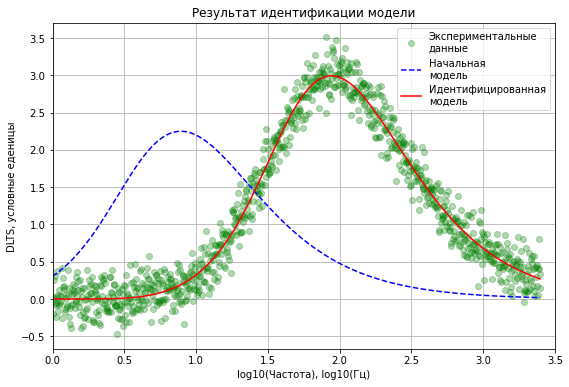

In [12]:
fig, ax = plot_model(data, initial_dlts, fs, freq_ix=2, dlts_ix=3)

plt.savefig('../plots/identification_test.pdf', bbox_inches='tight')
plt.savefig('../plots/identification_test.jpg', bbox_inches='tight')

plt.show()

### 3.8. График изменения параметров во время оптимизации

In [13]:
def get_mse(x, y, model, freq, dlts):
    
    model.time_constant_power = tf.Variable(y, dtype='float64')
    model.amplitude = tf.Variable(x, dtype='float64')
    
    
    mse = tf.reduce_mean(tf.square(dlts - model(freq))).numpy()

    return mse

def get_mse_grid(time_constant_powers, 
                 amplitudes, 
                 model, 
                 actual_freq, 
                 actual_dlts, 
                 n_jobs=1):
    
    X, Y = np.meshgrid(amplitudes, time_constant_powers)
    
    x = X.flatten()
    y = Y.flatten()
    
    Z = Parallel(n_jobs=n_jobs)(delayed(get_mse)(a, b, fs, data[:,2], data[:,3]) for a, b in zip(x, y))
    Z = np.reshape(np.c_[Z], X.shape)
    
    return X, Y, Z

def plot_path(X, Y, Z, 
              x_path, 
              y_path, 
              x_label='amplitude',
              y_label='time constant power'
             ):
    
    fig, ax = plt.subplots(figsize=(14,10))
    CS = ax.contour(X, Y, Z, 
                    levels=[0, 0.05, 0.1, 0.25, 0.5, 1, 2.0, 3.0, 4.0, 5.0], 
                    colors='k')
    ax.clabel(CS, 
              inline=True, 
              fontsize=12)

    IM = ax.imshow(Z, 
                   interpolation='bilinear', 
                   origin='lower',
                   cmap=cm.PuBuGn, 
                   extent=(np.min(X), np.max(X), np.min(Y), np.max(Y)), 
                   vmin=0, 
                   vmax=np.round(Z.max()))

    ax.plot(x_path, y_path, 'o-r')
    
    cbar = fig.colorbar(IM, shrink=1)
    cbar.ax.set_ylabel('Среднеквадратическая ошибка')

    ax.set_title('Значения параметров модели в процессе идентификации')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.grid()
    
    return fig, ax

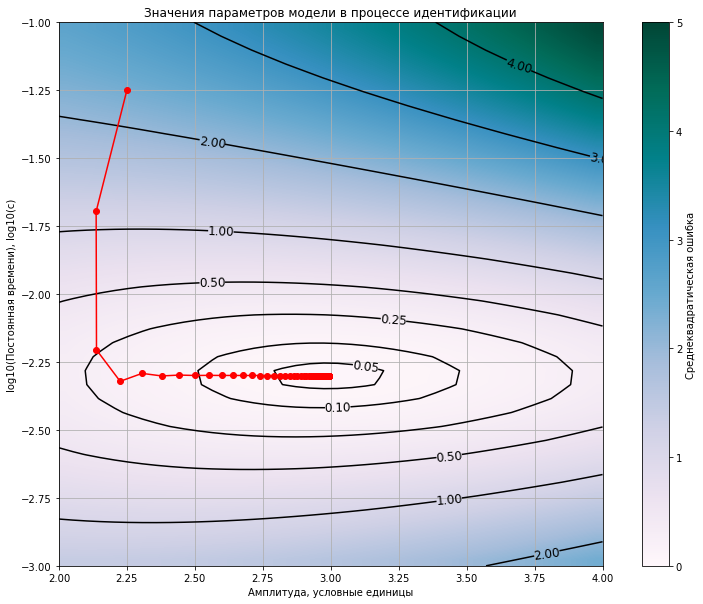

In [14]:
amplitudes = np.linspace(2, 4, 40)
time_constant_powers = np.linspace(-3, -1, 40)

X, Y, Z = get_mse_grid(time_constant_powers = time_constant_powers, 
                       amplitudes = amplitudes,
                       model = fs,
                       actual_freq = data[:, 2],
                       actual_dlts = data[:, 3],
                       n_jobs=-1
                      )

fig, ax = plot_path(X, Y, Z, 
                    x_path=fit_results.amplitude.to_numpy(),
                    y_path=fit_results.time_constant_power.to_numpy(), 
                    x_label='Амплитуда, yсловные единицы',
                    y_label='log10(Постоянная времени), log10(с)')

plt.savefig('../plots/path.pdf', bbox_inches='tight')
plt.savefig('../plots/path.jpg', bbox_inches='tight')
                    
plt.show()